In [43]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [44]:
from sklearn.datasets import load_diabetes

In [45]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [47]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [48]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [49]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [50]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [60]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, depth, trs):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    mse_train = mean_squared_error(y_train, train_prediction)
    
    print(f'Ошибка алгоритма из {trs} деревьев глубиной {depth} \
    с шагом {eta} на тренировочной выборке: {mse_train}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    mse_test = mean_squared_error(y_test, test_prediction)

    print(f'Ошибка алгоритма из {trs} деревьев глубиной {depth} \
    с шагом {eta} на тестовой выборке: {mse_test}')
    
    return mse_train, mse_test

In [61]:
trees_f = []
depth_f = []
mse_ftrain = []
mse_ftest = []

n_trees = [10,15,25,50]

# Максимальная глубина деревьев
max_depth = [3,4,5]

# Шаг
eta = 1

for trs in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * trs
    for depth in max_depth:
        
        trees, train_errors, test_errors = gb_fit(trs, depth, X_train, X_test, y_train, y_test, coefs, eta)
        
        mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, depth, trs)
        
        print(trs, depth, mse_train, mse_test)
        trees_f.append(trs)
        depth_f.append(depth)
        mse_ftrain.append(mse_train)
        mse_ftest.append(mse_test)
            

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 986.9366841713119
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6663.062034625852
10 3 986.9366841713119 6663.062034625852
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 1 на тренировочной выборке: 403.347335726934
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 1 на тестовой выборке: 6939.710654702506
10 4 403.347335726934 6939.710654702506
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 67.94591566187452
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тестовой выборке: 7712.430559725743
10 5 67.94591566187452 7712.430559725743
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 697.8990978300341
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 1 на тестовой выборке: 7104.066207838363
15 3 697.8990978300341 7104.066207838363
Ошибка алгоритма из 15 деревьев глубиной 4     с ш

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [12]:
import matplotlib.pyplot as plt

In [72]:
# trees_f, depth_f, mse_ftrain, mse_ftest

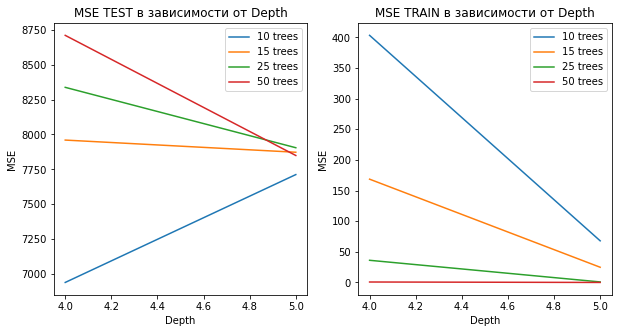

In [88]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('MSE TEST в зависимости от Depth')
plt.xlabel(r'Depth')
plt.ylabel(r'MSE')
plt.plot(depth_f[1:3], mse_ftest[1:3], depth_f[4:6], mse_ftest[4:6], depth_f[7:9], mse_ftest[7:9], depth_f[10:12], mse_ftest[10:12])
plt.legend(("10 trees", "15 trees", "25 trees", "50 trees"))

plt.subplot(122)
plt.title('MSE TRAIN в зависимости от Depth')
plt.xlabel(r'Depth')
plt.ylabel(r'MSE')
plt.plot(depth_f[1:3], mse_ftrain[1:3], depth_f[4:6], mse_ftrain[4:6], depth_f[7:9], mse_ftrain[7:9], depth_f[10:12], mse_ftrain[10:12])
plt.legend(("10 trees", "15 trees", "25 trees", "50 trees"))

При параметре деревьев ниже 15, модель ведет себя разнонаправлено: увеличение глубины дает большую ошибку на тестовой выборке. При параметре деревьев выше 15-25 идет существнное падение MSE TRAIN and MSE Test при увеличении глубины. При количестве деревьев более 25, при увеличении глубины, ошибка тестовой выборки существенно снижается, train снижается не существенно. 